In [1]:
import numpy as np
import pandas as pd

In [2]:
# 节省内存读文件
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    @param df:
    @return:
    """
    start_mem = df.memory_usage().sum()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('str')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

### 用户表

In [3]:
train_user = reduce_mem_usage(pd.read_csv('../input/train/train_user.csv'))
test_user = reduce_mem_usage(pd.read_csv('../input/test/test_user.csv'))

Memory usage of dataframe is 635152.00 MB
Memory usage after optimization is: 256580.00 MB
Decreased by 59.6%
Memory usage of dataframe is 81928.00 MB
Memory usage after optimization is: 55343.00 MB
Decreased by 32.4%


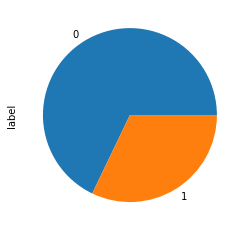

In [4]:
train_user.label.value_counts().plot.pie()

In [5]:
train_user['label'].mean()

0.321323288568621

In [6]:
train_user.shape, test_user.shape

((6106, 13), (2045, 5))

In [7]:
# 训练集只取最后一个月的数据
train_user['arpu_202004'] = train_user['arpu_202003']

train_user.drop(['arpu_201908', 'arpu_201909', 'arpu_201910', 'arpu_201911',
                 'arpu_201912', 'arpu_202001', 'arpu_202002', 'arpu_202003'],
                axis=1,
                inplace=True)

In [8]:
train_user.shape, test_user.shape

((6106, 6), (2045, 5))

In [9]:
train_user.nunique().sort_values(ascending=False)

phone_no_m     6106
arpu_202004    2200
county_name     182
city_name        23
idcard_cnt       11
label             2
dtype: int64

In [10]:
train_user.to_hdf('../input/train_user.h5', 'df')
test_user.to_hdf('../input/test_user.h5', 'df')

### 通话表

In [11]:
train_voc = reduce_mem_usage(pd.read_csv('../input/train/train_voc.csv'))
test_voc = reduce_mem_usage(pd.read_csv('../input/test/test_voc.csv'))

C:\Users\z\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Memory usage of dataframe is 320987648.00 MB
Memory usage after optimization is: 255787058.00 MB
Decreased by 20.3%
Memory usage of dataframe is 17697536.00 MB
Memory usage after optimization is: 14102750.00 MB
Decreased by 20.3%


In [12]:
# 只取最后一个月的数据
train_voc = train_voc[train_voc['start_datetime'] >= '2020-03-01 00:00:00']

In [13]:
train_voc.shape, test_voc.shape

((709144, 8), (276522, 8))

In [14]:
train_voc.nunique().sort_values(ascending=False)

start_datetime    561615
opposite_no_m     281103
imei_m              6025
phone_no_m          4823
call_dur            2653
county_name          193
city_name             22
calltype_id            3
dtype: int64

In [15]:
train_voc.to_hdf('../input/train_voc.h5', 'df')
test_voc.to_hdf('../input/test_voc.h5', 'df')

### 短信表

In [16]:
train_sms = reduce_mem_usage(pd.read_csv('../input/train/train_sms.csv'))
test_sms = reduce_mem_usage(pd.read_csv('../input/test/test_sms.csv'))

Memory usage of dataframe is 219152416.00 MB
Memory usage after optimization is: 171212853.00 MB
Decreased by 21.9%
Memory usage of dataframe is 13084928.00 MB
Memory usage after optimization is: 10222628.00 MB
Decreased by 21.9%


In [17]:
train_sms = train_sms[train_sms['request_datetime'] >= '2020-03-01 00:00:00']

In [18]:
train_sms.shape, test_sms.shape

((910606, 4), (408900, 4))

In [19]:
train_sms.nunique().sort_values(ascending=False)

request_datetime    496383
opposite_no_m       104792
phone_no_m            4867
calltype_id              2
dtype: int64

In [20]:
test_sms.nunique().sort_values(ascending=False)

request_datetime    262492
opposite_no_m        96779
phone_no_m            2008
calltype_id              2
dtype: int64

In [21]:
train_sms.to_hdf('../input/train_sms.h5', 'df')
test_sms.to_hdf('../input/test_sms.h5', 'df')

### 应用表

In [22]:
train_app = reduce_mem_usage(pd.read_csv('../input/train/train_app.csv'))
test_app = reduce_mem_usage(pd.read_csv('../input/test/test_app.csv'))

Memory usage of dataframe is 105075392.00 MB
Memory usage after optimization is: 91940984.00 MB
Decreased by 12.5%
Memory usage of dataframe is 4142624.00 MB
Memory usage after optimization is: 3365906.00 MB
Decreased by 18.7%


In [23]:
train_app = train_app[train_app['month_id'] == '2020-03']

In [24]:
train_app.shape, test_app.shape

((382647, 4), (129453, 4))

In [25]:
train_app.nunique().sort_values(ascending=False)

flow          281286
phone_no_m      4006
busi_name       3255
month_id           1
dtype: int64

In [26]:
test_app.nunique().sort_values(ascending=False)

flow          21057
busi_name      2465
phone_no_m     2045
month_id          2
dtype: int64

In [27]:
train_app.to_hdf('../input/train_app.h5', 'df')
test_app.to_hdf('../input/test_app.h5', 'df')